In [1]:
!pip install transformers

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import pickle
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import transformers
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [8]:
train_df= pd.read_csv('sample_data/train_c.csv', encoding='utf-8')
train_df.shape

(10053, 2)

In [9]:
#labeling
reviews = np.array(train_df['text'])[:]
labels = np.array(train_df['sentiment'])[:]
print(Counter(labels))

Counter({'joy': 3389, 'sadness': 2925, 'anger': 1361, 'fear': 1187, 'love': 840, 'surprise': 350, nan: 1})


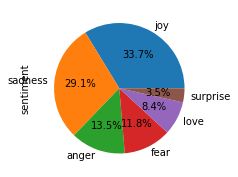

In [10]:
#plot_train data
import matplotlib.pyplot as plt
label_count = train_df['sentiment'].value_counts()
plot_users=label_count.plot.pie(autopct='%1.1f%%', figsize=(3, 3))
plt.rc('axes', unicode_minus=False)

In [11]:
test_df= pd.read_csv('sample_data/test_c.csv', encoding='utf-8')
test_df.shape

(12168, 2)

In [12]:
#labeling
reviews = np.array(test_df['text'])[:]
labels = np.array(test_df['sentiment'])[:]
print(Counter(labels))

Counter({'fear': 2028, 'sadness': 2028, 'joy': 2028, 'surprise': 2028, 'love': 2028, 'anger': 2028})


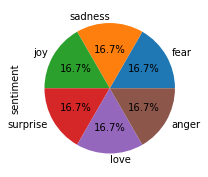

In [13]:
#plot test data
import matplotlib.pyplot as plt
label_count = test_df['sentiment'].value_counts()
plot_users=label_count.plot.pie(autopct='%1.1f%%', figsize=(3, 3))
plt.rc('axes', unicode_minus=False)

In [14]:
def clean_text(text):
    import re
    from string import punctuation
    text=re.sub(r'(http|ftp|https):\/\/([\w\-_]+(?:(?:\.[\w\-_]+)+))([\w\-\.,@?^=%&:/~\+#]*[\w\-\@?^=%&/~\+#])?', 
                ' ', text)
    text=re.sub(r'['+punctuation+']',' ',text)
    text=re.sub(r'#(\w+)',' ',text)
    text=re.sub(r'@(\w+)',' ',text)
    text = text.lower() # Convert  to lowercase

    token=RegexpTokenizer(r'\w+')
    tokens = token.tokenize(text)

    lemmatizer = WordNetLemmatizer()
    stems = [lemmatizer.lemmatize(t) for t in tokens]
    stemmer = PorterStemmer()
    stems = [stemmer.stem(t) for t in stems]
    
    return ' '.join(stems)

def tokenize(text):
    token=RegexpTokenizer(r'\w+')
    tokens = token.tokenize(text)
    
    return tokens
    

In [15]:
# cv = TfidfVectorizer(lowercase=True, preprocessor=clean_text, stop_words='english',
#                      ngram_range=(1,3), tokenizer=tokenize)
# text_counts = cv.fit_transform(train_df['text'].values.astype('U'))

# x_train, x_test, y_train, y_test = train_test_split(text_counts, train_df['sentiment'],
#                                                     stratify=train_df['sentiment'], test_size=0.3, shuffle=True)

In [16]:
# Define the vectorizer and fit it to the training data
cv = TfidfVectorizer(lowercase=True, preprocessor=clean_text, stop_words='english',
                             ngram_range=(1,3), tokenizer=tokenize)

x_train = cv.fit_transform(train_df['text'].values.astype('U'))
y_train = train_df['sentiment']

# Vectorize the test data using the same vectorizer
x_test = cv.transform(test_df['text'].values.astype('U'))
y_test = test_df['sentiment']

In [17]:
#DistilBert WITHOUT BATCH NORMALIZATION

tf.keras.mixed_precision.set_global_policy('mixed_float16')
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=10000)
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=128)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=128)

# Load pre-trained model
model = transformers.TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

model.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_test, y_test))

17464789/17464789 [==============================] - 0s 0us/step


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/2


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


782/782 [==============================] - 253s 290ms/step - loss: 0.6023 - sparse_categorical_accuracy: 0.6342 - val_loss: 0.3865 - val_sparse_categorical_accuracy: 0.8307
Epoch 2/2
782/782 [==============================] - 201s 257ms/step - loss: 0.3308 - sparse_categorical_accuracy: 0.8596 - val_loss: 0.3176 - val_sparse_categorical_accuracy: 0.8613


In [18]:
#DistilBert WITH BATCH NORMALIZATION

tf.keras.mixed_precision.set_global_policy('mixed_float16')
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=10000)
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=128)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=128)

# Load pre-trained model
model = transformers.TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

# Add batch normalization layers
model.layers[0].layer_norm = tf.keras.layers.BatchNormalization()
for layer in model.layers[1:]:
    if hasattr(layer, 'activation'):
        layer.activation = tf.keras.layers.LeakyReLU(alpha=0.1)
        layer.layer_norm = tf.keras.layers.BatchNormalization()

def train_models():
    file = open('C:/Users/Asus/PYTHON_C/DLBBT01/src/code_model_deploy/deep_learning/vectorizer.pickle','wb')
    pickle.dump(cv, file)
    file.close()

    file = open('C:/Users/Asus/PYTHON_C/DLBBT01/src/code_model_deploy/deep_learning/model.pickle','wb')
    pickle.dump(model, file)
    file.close()
    
    print("Models saved")

model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_39', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/10
782/782 [==============================] - 277s 325ms/step - loss: 0.6878 - sparse_categorical_accuracy: 0.5329 - val_loss: 0.6136 - val_sparse_categorical_accuracy: 0.6535
Epoch 2/10
782/782 [==============================] - 232s 297ms/step - loss: 0.3995 - sparse_categorical_accuracy: 0.8160 - val_loss: 0.3375 - val_sparse_categorical_accuracy: 0.8551
Epoch 3/10
782/782 [==============================] - 229s 292ms/step - loss: 0.2754 - sparse_categorical_accuracy: 0.8869 - val_loss: 0.3559 - val_sparse_categorical_accuracy: 0.8597
Epoch 4/10
782/782 [==============================] - 198s 253ms/step - loss: 0.2197 - sparse_categorical_accuracy: 0.9154 - val_loss: 0.3482 - val_sparse_categorical_accuracy: 0.8578
Epoch 5/10
782/782 [==============================] - 232s 297ms/step - loss: 0.1768 - sparse_categorical_accuracy: 0.9351 - val_loss: 0.3740 - val_sparse_categorical_accuracy: 0.8491
Epoch 6/10
782/782 [==============================] - 228s 291ms/step - loss: 0.